# Baseline Comparisons

## Load Models

In [28]:
import torch
import pandas as pd
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

bart_id = "facebook/bart-large-cnn"
t5_id = "google-t5/t5-base"

bart_tokenizer = AutoTokenizer.from_pretrained(bart)
bart_model = AutoModelForSeq2SeqLM.from_pretrained(bart_id)

t5_tokenizer = AutoTokenizer.from_pretrained(t5_id)
t5_model = AutoModelForSeq2SeqLM.from_pretrained(t5_id)

Loading weights: 100%|██████████| 257/257 [00:00<00:00, 858.61it/s, Materializing param=shared.weight]                                                       


## Generate Summaries by having models use this logic

In [12]:
def generate_summary(text, model, tokenizer):  
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=1024)

    with torch.no_grad():
        summary_ids = model.generate(
            inputs["input_ids"],
            num_beams=4,
            max_length=128,
            min_length=30,
            no_repeat_ngram_size=3, # prevents loops
            length_penalty=2.0,     # standard penalty
            early_stopping=True
        )

    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

## Evaluate

In [30]:
# replace with real data later
test_data = [
    {"source": "The James Webb Space Telescope has captured a stunning image of the Pillars of Creation in high-definition infrared.", "ref": "Webb telescope captures HD infrared images of Pillars of Creation."},
    {"source": "New research suggests that microplastics are now appearing in cloud formations, potentially affecting weather patterns.", "ref": "Microplastics found in clouds may impact global weather."}
]

results = []
for sample in tqdm(test_data):
    results.append({
        "Reference": sample['ref'],
        "BART": generate_summary(sample['source'], bart_model, bart_tokenizer),
        "T5-Base": generate_summary(sample['source'], t5_model, t5_tokenizer)
    })

df_results = pd.DataFrame(results)
df_results.head()

100%|██████████| 2/2 [00:16<00:00,  8.29s/it]


,Reference,BART,T5-Base
0,Webb telescope captures HD infrared images of ...,The James Webb Space Telescope has captured a ...,has captured a stunning image of the Pillars o...
1,Microplastics found in clouds may impact globa...,New research suggests that microplastics are n...,microplastics are now appearing in cloud forma...


## ROUGE & BERTScore

In [33]:
import evaluate
rouge = evaluate.load("rouge")
bertscore = evaluate.load("bertscore")

def calc_metrics(preds, refs):
    r = rouge.compute(predictions=preds, references=refs)
    b = bertscore.compute(predictions=preds, references=refs, lang="en")
    return {
        "ROUGE": r,
        "BERTScore-F1": sum(b['f1']) / len(b['f1'])
    }

bart_scores = calc_metrics(df_results["BART"], df_results["Reference"])
t5_scores = calc_metrics(df_results["T5-Base"], df_results["Reference"])

print("BART Scores: ", bart_scores)
print("T5 Scores: ", t5_scores)

Loading weights: 100%|██████████| 389/389 [00:00<00:00, 991.42it/s, Materializing param=encoder.layer.23.output.dense.weight]               
RobertaModel LOAD REPORT from: roberta-large
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.bias              | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
pooler.dense.weight             | MISSING    | 
pooler.dense.bias               | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


BART Scores:  {'ROUGE': {'rouge1': np.float64(0.28088235294117647), 'rouge2': np.float64(0.0625), 'rougeL': np.float64(0.2514705882352941), 'rougeLsum': np.float64(0.2514705882352941)}, 'BERTScore-F1': 0.9196314811706543}
T5 Scores:  {'ROUGE': {'rouge1': np.float64(0.3270944741532977), 'rouge2': np.float64(0.09475806451612903), 'rougeL': np.float64(0.23885918003565063), 'rougeLsum': np.float64(0.23885918003565063)}, 'BERTScore-F1': 0.919925719499588}


## Visualize Scores

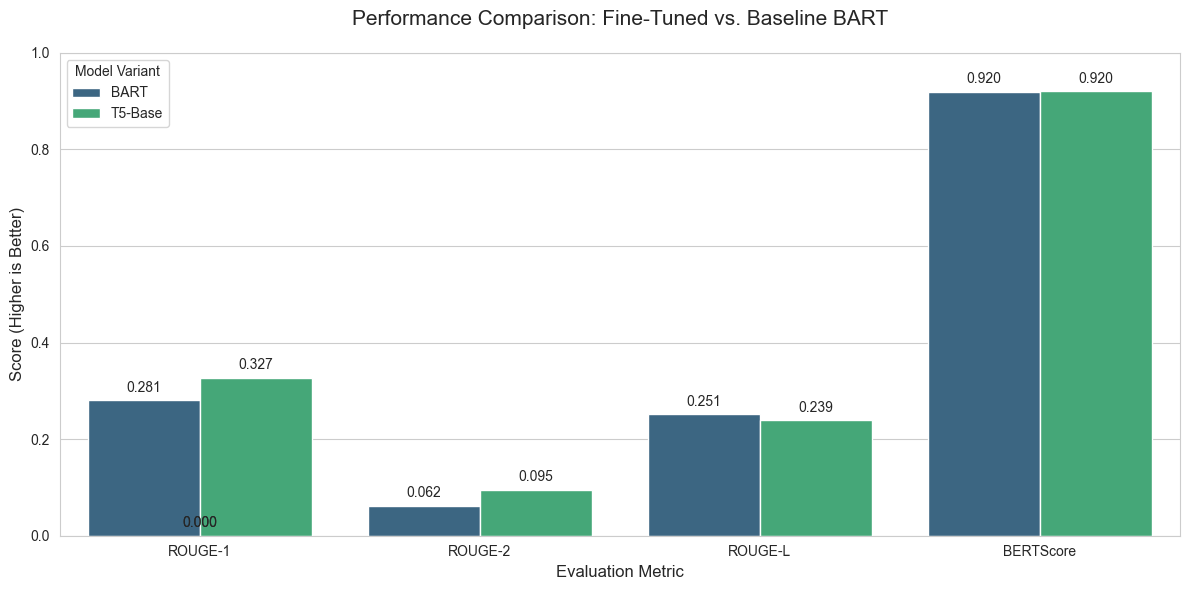

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics_data = {
    "Metric": ["ROUGE-1", "ROUGE-2", "ROUGE-L", "BERTScore"],
    "BART": [
        bart_scores["ROUGE"]["rouge1"],
        bart_scores["ROUGE"]["rouge2"],
        bart_scores["ROUGE"]["rougeL"],
        bart_scores["BERTScore-F1"]
    ],
    "T5-Base": [
        t5_scores["ROUGE"]["rouge1"],
        t5_scores["ROUGE"]["rouge2"],
        t5_scores["ROUGE"]["rougeL"],
        t5_scores["BERTScore-F1"]
    ]
}

df_plot = pd.DataFrame(metrics_data)
# don't know what this is yet
df_melted = df_plot.melt(id_vars="Metric", var_name="Model", value_name="Score")

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# bar chart
bar_chart = sns.barplot(data=df_melted, x="Metric", y="Score", hue="Model", palette="viridis")

# styling
plt.title("Performance Comparison: Fine-Tuned vs. Baseline BART", fontsize=15, pad=20)
plt.ylim(0, 1.0)
plt.ylabel("Score (Higher is Better)", fontsize=12)
plt.xlabel("Evaluation Metric", fontsize=12)
plt.legend(title="Model Variant", loc='upper left')

# add labels to bars
for p in bar_chart.patches:
    bar_chart.annotate(format(p.get_height(), '.3f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points',
                fontsize=10)

plt.tight_layout()
plt.show()

# Extractive vs. Abstractive Summarization Analysis

# Input Length Sensitivity

# Domain Generalization

# Compression Ratio